# Cross-site Pairing Tutorial

In this notebook, we perform a subset of the cross-site benchmarking.

In [1]:
import os
os.environ['NUMBA_CACHE_DIR'] = '/scratch/st-jiaruid-1/yinian/tmp/' # https://github.com/scverse/scanpy/issues/2113
os.environ['MPLCONFIGDIR'] = "/scratch/st-jiaruid-1/yinian/tmp/"

import gc

In [2]:
import anndata as ad
import matplotlib.pyplot as plt
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy
import sklearn
import torch

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11

In [3]:
from scPairing.scPairing import scPairing
from scPairing.eval_utils import foscttm

## Load the data

Download and unzip the `.h5ad` file from NCBI GEO.

In [ ]:
# Download the 2021 NeurIPS challenge dataset
!wget -O data/bmmc.h5ad.gz "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE194122&format=file&file=GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed%2Eh5ad%2Egz"
!gzip -d data/bmmc.h5ad.gz

In [4]:
adata = ad.read_h5ad('data/bmmc.h5ad')

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_pct_counts_mt' was written without encoding metadata.
  return func(*args, **kwargs)
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_n_counts' was written without encoding metadata.
  return func(*args, **kwargs)
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_n_genes' was written without encoding metadata.
  return func(*args, **kwargs)
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_io/utils.py:202: OldFo

In [5]:
rna_adata = adata[:, adata.var.feature_types == 'GEX'].copy()
atac_adata = adata[:, adata.var.feature_types == 'ATAC']. copy()

In [6]:
del adata

## Run scVI and PeakVI on three of four sites

This builds the model that we will transfer the fourth site onto.

In [7]:
import sys
sys.path.insert(0, '/arc/project/st-jiaruid-1/yinian/scCLIP_storage/libraries/scvi-tools/')

import scvi

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_LOWER_3_8 = LooseVersion(_PYTHON_VERSION) < LooseVersion("3.8")
[2024-08-22 12:59:48,242] INFO - torch.distributed.nn.jit.instantiator: Created a temporary directory at /tmp/slurm/2010308/tmpe8rx1wd7
[2024-08-22 12:59:48,244] INFO - torch.distributed.nn.jit.instantiator: Writing /tmp/slurm/2010308/tmpe8rx1wd7/_remote_module_non_scriptable.py


In [8]:
scvi.settings.seed = 0

INFO: [rank: 0] Global seed set to 0
[2024-08-22 13:00:04,922] INFO - lightning.fabric.utilities.seed: [rank: 0] Global seed set to 0


### Subset the data to the first three sites

In [9]:
rna_adata_ref = rna_adata[~rna_adata.obs.batch.str.startswith('s4')].copy()
atac_adata_ref = atac_adata[~atac_adata.obs.batch.str.startswith('s4')].copy()

### Run scVI

In [10]:
scvi.model.SCVI.setup_anndata(rna_adata_ref, batch_key='batch', layer='counts')

[2024-08-22 13:00:55,169] INFO - jax._src.xla_bridge: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[2024-08-22 13:00:55,170] INFO - jax._src.xla_bridge: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[2024-08-22 13:00:55,298] INFO - jax._src.xla_bridge: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[2024-08-22 13:00:55,299] WARNING - jax._src.xla_bridge: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
scvi_ref = scvi.model.SCVI(rna_adata_ref)
scvi_ref.train(early_stopping=True)

INFO: GPU available: True (cuda), used: True
[2024-08-22 13:01:02,217] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-08-22 13:01:02,220] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-08-22 13:01:02,222] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-08-22 13:01:02,225] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-08-22 13:01:17,746] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-08-22 13:01:17,767] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 170/170: 100%|██████████| 170/170 [13:03<00:00,  4.51s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.04e+3]

INFO: `Trainer.fit` stopped: `max_epochs=170` reached.
[2024-08-22 13:14:21,201] INFO - lightning.pytorch.utilities.rank_zero: `Trainer.fit` stopped: `max_epochs=170` reached.


Epoch 170/170: 100%|██████████| 170/170 [13:03<00:00,  4.61s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.04e+3]


/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


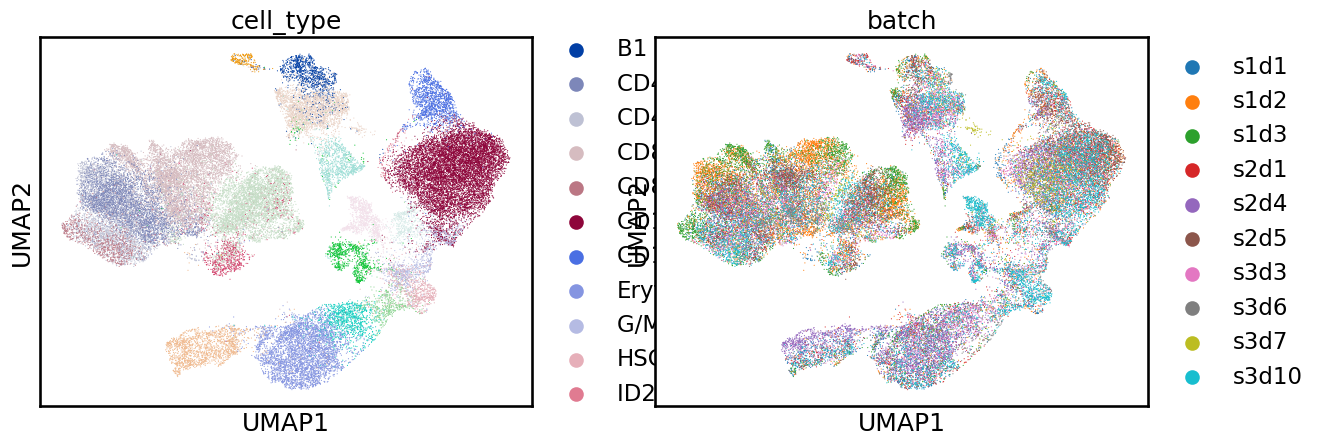

In [12]:
latents = scvi_ref.get_latent_representation()
rna_adata_ref.obsm['X_scVI'] = latents

sc.pp.neighbors(rna_adata_ref, use_rep='X_scVI', random_state=0)
sc.tl.umap(rna_adata_ref, random_state=0)
sc.pl.umap(rna_adata_ref, color=['cell_type', 'batch'])

In [13]:
scvi_ref.save(dir_path='data', prefix='scvi_ref_', overwrite=True)

### Run PeakVI

In [14]:
scvi.model.PEAKVI.setup_anndata(atac_adata_ref, batch_key="batch", layer="counts")

In [15]:
peakvi_ref = scvi.model.PEAKVI(atac_adata_ref)
peakvi_ref.train(early_stopping=True)

INFO: GPU available: True (cuda), used: True
[2024-08-22 13:18:45,240] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-08-22 13:18:45,243] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-08-22 13:18:45,245] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-08-22 13:18:45,247] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-08-22 13:18:45,362] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-08-22 13:18:45,366] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 78/500:  16%|█▌        | 78/500 [34:10<3:04:52, 26.29s/it, v_num=1, train_loss_step=7.38e+7, train_loss_epoch=1.75e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 11353.339. Signaling Trainer to stop.


/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


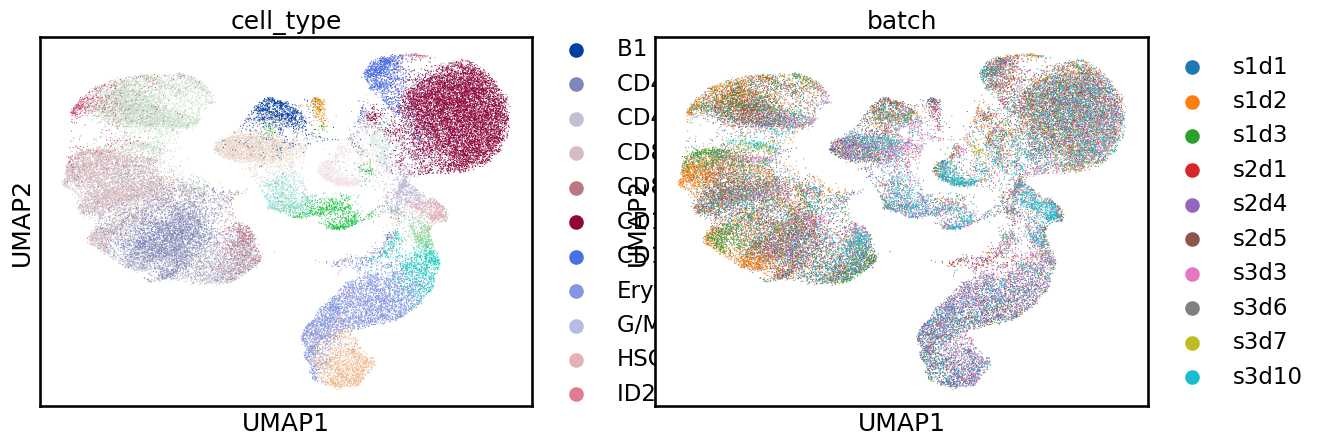

In [16]:
latents = peakvi_ref.get_latent_representation()
atac_adata_ref.obsm['X_PeakVI'] = latents

sc.pp.neighbors(atac_adata_ref, use_rep='X_PeakVI', random_state=0)
sc.tl.umap(atac_adata_ref, random_state=0)
sc.pl.umap(atac_adata_ref, color=['cell_type', 'batch'])

In [17]:
peakvi_ref.save(dir_path='data', prefix='peakvi_ref_', overwrite=True)

### Perform mapping on the individual modalities

We subset the full data for the fourth site and map the data onto the three training sites.

In [18]:
rna_adata_val = rna_adata[rna_adata.obs.batch.str.startswith('s4')].copy()
atac_adata_val = atac_adata[atac_adata.obs.batch.str.startswith('s4')].copy()

In [19]:
scvi.model.SCVI.prepare_query_anndata(rna_adata_val, scvi_ref)

INFO     Found 100.0% reference vars in query data.                                                                


In [20]:
scvi_query = scvi.model.SCVI.load_query_data(rna_adata_val, scvi_ref)
scvi_query.train(max_epochs=200, early_stopping=True, plan_kwargs={"weight_decay": 0.0})

INFO: GPU available: True (cuda), used: True
[2024-08-22 13:54:11,527] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-08-22 13:54:11,530] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-08-22 13:54:11,532] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-08-22 13:54:11,534] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-08-22 13:54:11,543] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-08-22 13:54:11,547] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 57/200:  28%|██▊       | 57/200 [01:50<04:37,  1.94s/it, v_num=1, train_loss_step=2.48e+3, train_loss_epoch=2.49e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2549.416. Signaling Trainer to stop.


/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


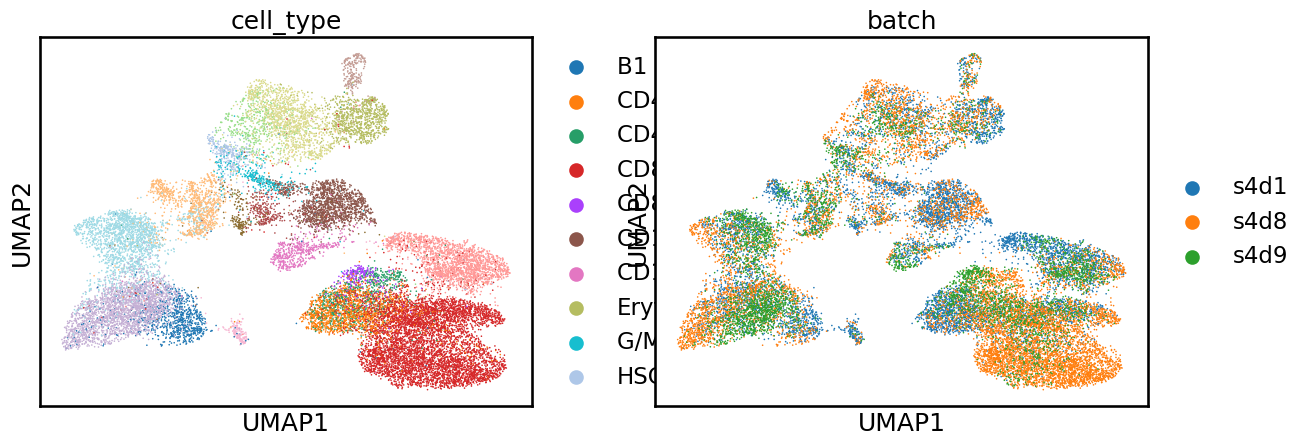

In [21]:
latents = scvi_query.get_latent_representation()
rna_adata_val.obsm['X_scVI'] = latents

sc.pp.neighbors(rna_adata_val, use_rep='X_scVI', random_state=0)
sc.tl.umap(rna_adata_val, random_state=0)
sc.pl.umap(rna_adata_val, color=['cell_type', 'batch'])

In [22]:
scvi_query.save(dir_path='data', prefix='scvi_query_', overwrite=True)

In [23]:
scvi.model.PEAKVI.prepare_query_anndata(atac_adata_val, peakvi_ref)

INFO     Found 100.0% reference vars in query data.                                                                


In [24]:
peakvi_query = scvi.model.PEAKVI.load_query_data(atac_adata_val, peakvi_ref)

In [25]:
peakvi_query.train(max_epochs=200, early_stopping=True, plan_kwargs={"weight_decay": 0.0})

INFO: GPU available: True (cuda), used: True
[2024-08-22 13:57:01,123] INFO - lightning.pytorch.utilities.rank_zero: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[2024-08-22 13:57:01,127] INFO - lightning.pytorch.utilities.rank_zero: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[2024-08-22 13:57:01,129] INFO - lightning.pytorch.utilities.rank_zero: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[2024-08-22 13:57:01,131] INFO - lightning.pytorch.utilities.rank_zero: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2024-08-22 13:57:01,140] INFO - lightning.pytorch.accelerators.cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
[2024-08-22 13:57:01,144] INFO - lightning.pytorch.trainer.connectors.signal_connector: SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 200/200: 100%|██████████| 200/200 [38:57<00:00, 11.71s/it, v_num=1, train_loss_step=1.46e+7, train_loss_epoch=2.1e+8]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
[2024-08-22 14:35:58,731] INFO - lightning.pytorch.utilities.rank_zero: `Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [38:57<00:00, 11.69s/it, v_num=1, train_loss_step=1.46e+7, train_loss_epoch=2.1e+8]


/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


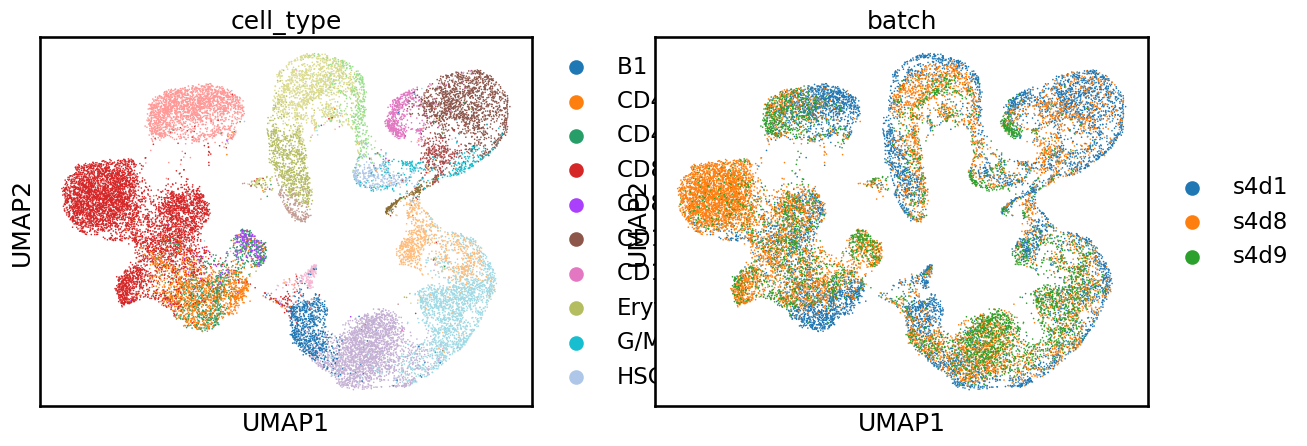

In [26]:
latents = peakvi_query.get_latent_representation()
atac_adata_val.obsm['X_PeakVI'] = latents

sc.pp.neighbors(atac_adata_val, use_rep='X_PeakVI', random_state=0)
sc.tl.umap(atac_adata_val, random_state=0)
sc.pl.umap(atac_adata_val, color=['cell_type', 'batch'])

In [27]:
peakvi_query.save(dir_path='data', prefix='peakvi_query_', overwrite=True)

## Run scPairing

The following code allows for using the scVI and PeakVI as pre-trained decoders.

In [29]:
def reconstruct_mod1(scvi_model):
    def f(mod2_features, true_features, counts, library_size, cell_indices, is_training, is_imputation, batch_indices=None):
        if is_training:
            return None, 0
        if batch_indices is None:
            batch_indices = torch.zeros(mod2_features.shape[0], device=mod2_features.device)
        library_size = torch.log(library_size) if not is_imputation else torch.ones((mod2_features.shape[0], 1))
        res = scvi_model.module.generative(mod2_features, library_size, batch_indices.reshape((mod2_features.shape[0], 1)))
        if is_imputation:
            return res['px'].mu, None
        loss = -res['px'].log_prob(counts).sum(-1).mean()
        return res['px'].mu, loss
    return f

def reconstruct_mod2(pvi_model):
    def f(mod1_features, true_features, counts, library_size, cell_indices, is_training, is_imputation, batch_indices=None):
        if is_training:
            return None, 0
        if batch_indices is None:
            batch_indices = torch.zeros(mod1_features.shape[0], device=mod1_features.device)
        res = pvi_model.module.generative(mod1_features, mod1_features, batch_indices.reshape((mod1_features.shape[0], 1)))
        if is_imputation:
            return res['p'], None
        dres = pvi_model.module.d_encoder(counts, batch_indices, ())
        region_factors = torch.sigmoid(pvi_model.module.region_factors)
        loss = pvi_model.module.get_reconstruction_loss(res['p'], dres, region_factors, counts).mean()
        return res['p'], loss
    return f

Now that the reference and query data have batch-corrected low-dimensional representations, we can run scPairing to re-pair the query cells.

In [30]:
model = scPairing(
    rna_adata_ref,
    atac_adata_ref,
    "rna", "atac",
    counts_layer=['counts', 'counts'],
    transformed_obsm=['X_scVI', 'X_PeakVI'],
    batch_discriminative=True,
    cosine_loss=True,
    use_decoder=True,
    reconstruct_mod1_fn=reconstruct_mod1(scvi_ref),
    reconstruct_mod2_fn=reconstruct_mod2(peakvi_ref),
    seed=0
)

[2024-08-22 14:42:09,972] WARNING - scPairing.models.model: With one batch provided, batch adversarial loss will be disabled


In [31]:
model.train(epochs = 300, batch_size=5000)

[2024-08-22 14:42:10,586] INFO - scPairing.logging_utils: UnsupervisedTrainer.__init__(Model(
  (mod1_encoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (mod2_encoder): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (var_encoder): ConcentrationEncoder(
    (mod1_encoder): Sequential(
      (0): Linear(in_features=10, out_features=32, bias=True)
      (1): ELU(alpha=1.0)
      (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_fea

[2024-08-22 14:42:11,291] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 0==========
[2024-08-22 14:42:11,293] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :        0.005
[2024-08-22 14:42:11,294] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-08-22 14:42:11,295] INFO - scPairing.trainers.trainer_utils: loss        :      17.75
[2024-08-22 14:42:11,297] INFO - scPairing.trainers.trainer_utils: contrastive :      14.53
[2024-08-22 14:42:11,298] INFO - scPairing.trainers.trainer_utils: KL          :    0.02372
[2024-08-22 14:42:11,299] INFO - scPairing.trainers.trainer_utils: mod1_loss   :      1.469
[2024-08-22 14:42:11,300] INFO - scPairing.trainers.trainer_utils: mod2_loss   :      2.439
[2024-08-22 14:42:11,301] INFO - scPairing.trainers.trainer_utils: temp        :      14.29
[2024-08-22 14:42:11,302] INFO - scPairing.trainers.trainer_utils: mod1_reconstruction_loss:          0
[2024-08-22 14:42:11,304] INFO - scPairing.

[2024-08-22 14:43:33,090] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 300==========
[2024-08-22 14:43:33,092] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :     0.004221
[2024-08-22 14:43:33,093] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-08-22 14:43:33,095] INFO - scPairing.trainers.trainer_utils: loss        :      4.044
[2024-08-22 14:43:33,096] INFO - scPairing.trainers.trainer_utils: contrastive :      5.035
[2024-08-22 14:43:33,098] INFO - scPairing.trainers.trainer_utils: KL          :      13.18
[2024-08-22 14:43:33,099] INFO - scPairing.trainers.trainer_utils: mod1_loss   :     0.3201
[2024-08-22 14:43:33,101] INFO - scPairing.trainers.trainer_utils: mod2_loss   :     0.3009
[2024-08-22 14:43:33,102] INFO - scPairing.trainers.trainer_utils: temp        :      31.98
[2024-08-22 14:43:33,104] INFO - scPairing.trainers.trainer_utils: mod1_reconstruction_loss:          0
[2024-08-22 14:43:33,105] INFO - scPairin

In [32]:
latents = model.get_latent_representation()

In [33]:
rna_adata_ref.obsm['mod1_features'] = atac_adata_ref.obsm['mod1_features'] = latents[0]
rna_adata_ref.obsm['mod2_features'] = atac_adata_ref.obsm['mod2_features'] = latents[1]

### Visualize and evaluate the embeddings

Visualization of the concatenated embeddings

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


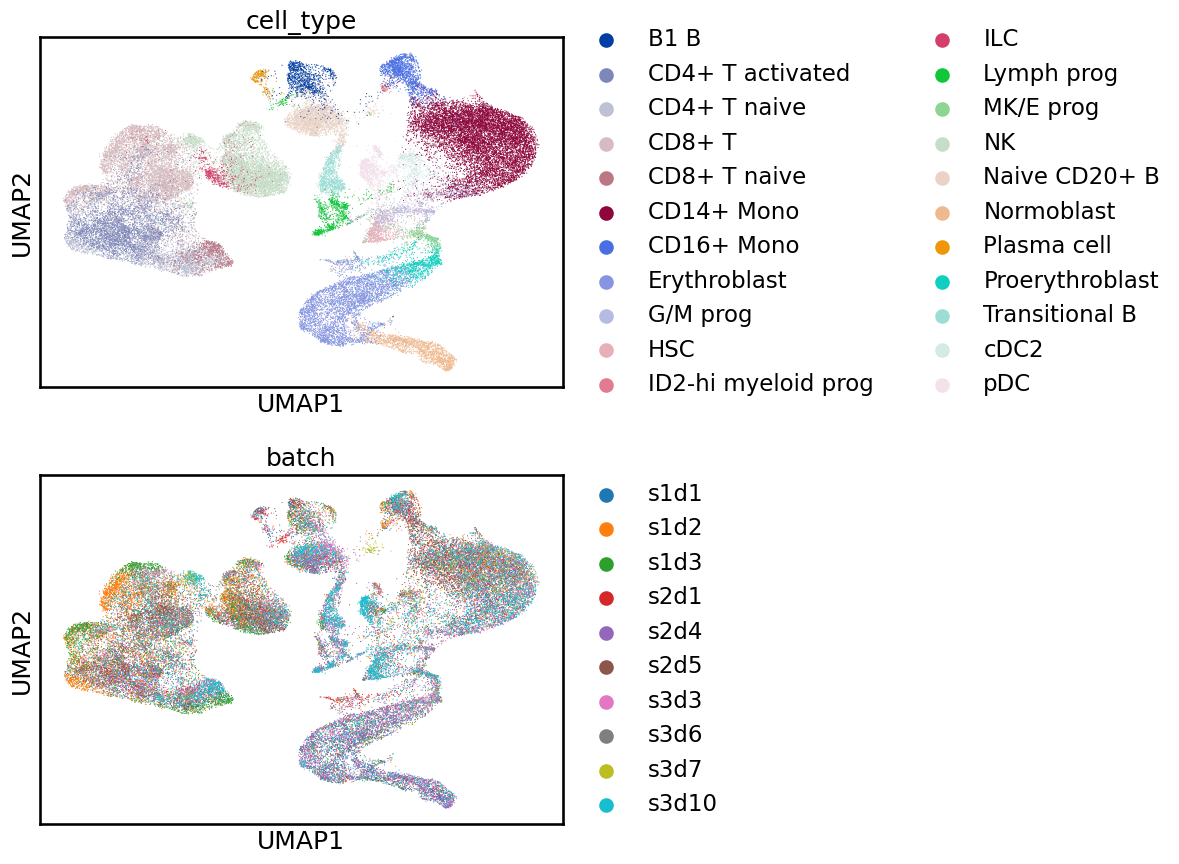

In [34]:
concat = np.concatenate((rna_adata_ref.obsm['mod1_features'], atac_adata_ref.obsm['mod2_features']), axis=1)
rna_adata_ref.obsm['concat'] = concat

sc.pp.neighbors(rna_adata_ref, use_rep='concat')
sc.tl.umap(rna_adata_ref)
sc.pl.umap(rna_adata_ref, color=['cell_type', 'batch'], ncols=1)

Visualization and evaluation of modality alignment

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Paramet

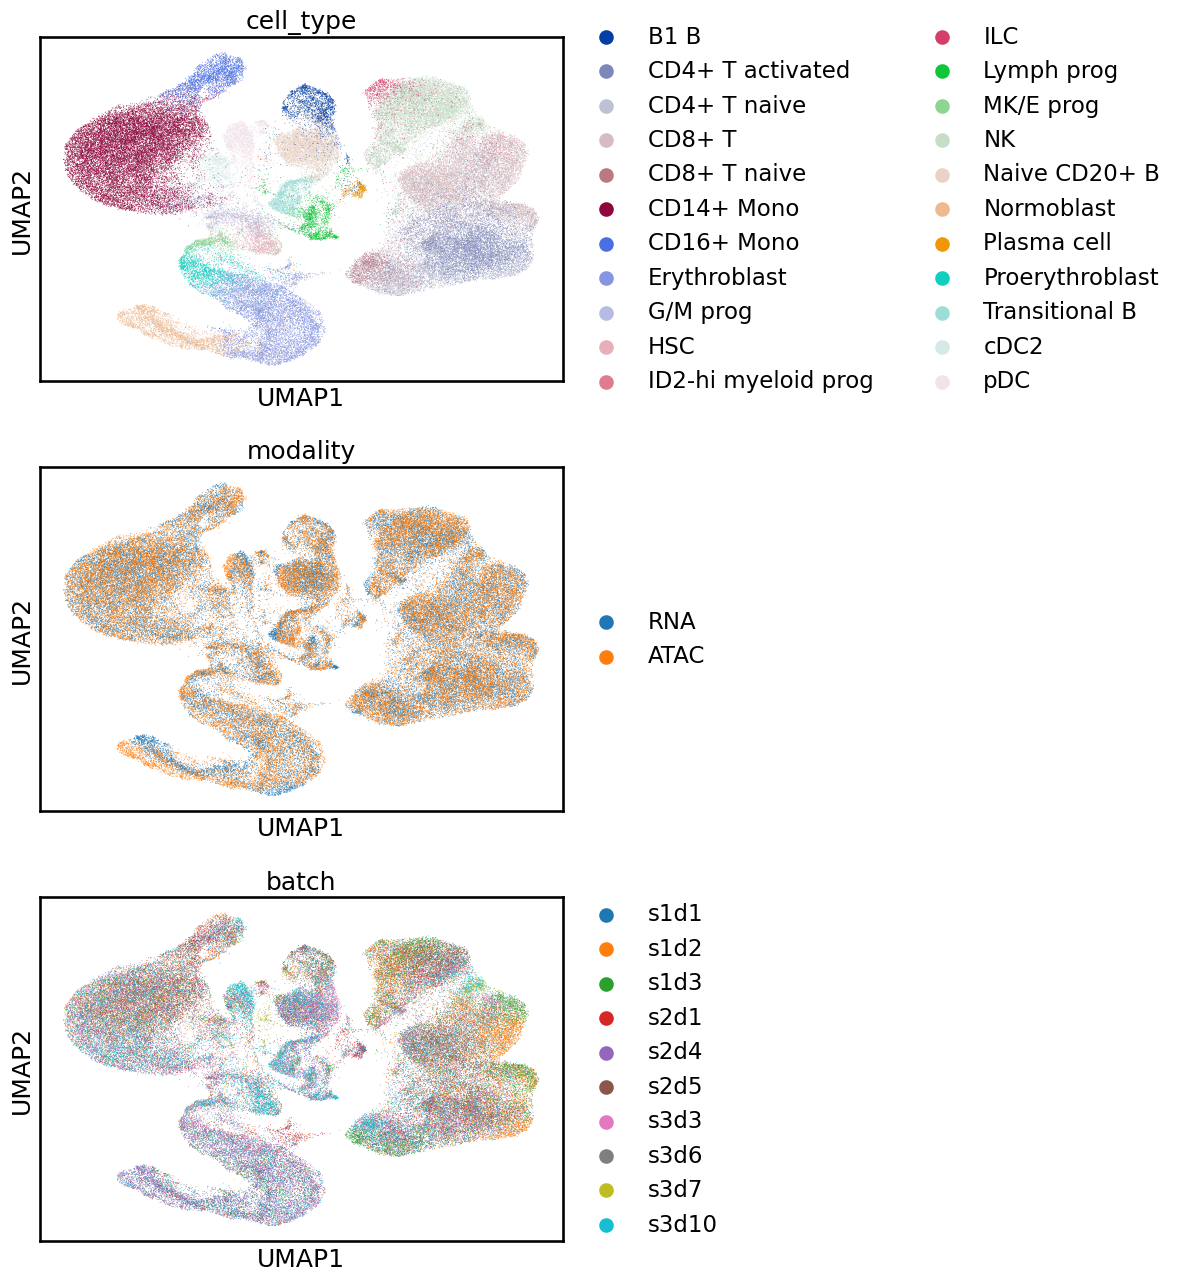

In [35]:
concat_feat = np.concatenate([rna_adata_ref.obsm['mod1_features'], atac_adata_ref.obsm['mod2_features']])
concat = ad.concat([rna_adata_ref, rna_adata_ref], label='modality', keys=['RNA', 'ATAC'])
concat.obsm['concat_feat'] = concat_feat

sc.pp.neighbors(concat, use_rep='concat_feat')
sc.tl.umap(concat)
sc.pl.umap(concat, color=['cell_type', 'modality', 'batch'], ncols=1)

In [36]:
scib.me.ilisi_graph(concat, batch_key="modality", type_="knn")

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


0.7756322746795763

In [37]:
scores = foscttm(rna_adata_ref.obsm['mod1_features'], atac_adata_ref.obsm['mod2_features'])
scores[0].mean(), scores[1].mean()

(0.01167342514939258, 0.011652768090541953)

## Map the query data onto the common embedding space

In [38]:
test_latents = model.get_latent_representation(rna_adata_val, atac_adata_val)
rna_adata_val.obsm['mod1_features'] = atac_adata_val.obsm['mod1_features'] = test_latents[0]
rna_adata_val.obsm['mod2_features'] = atac_adata_val.obsm['mod2_features'] = test_latents[1]

### Visualize the mappings

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


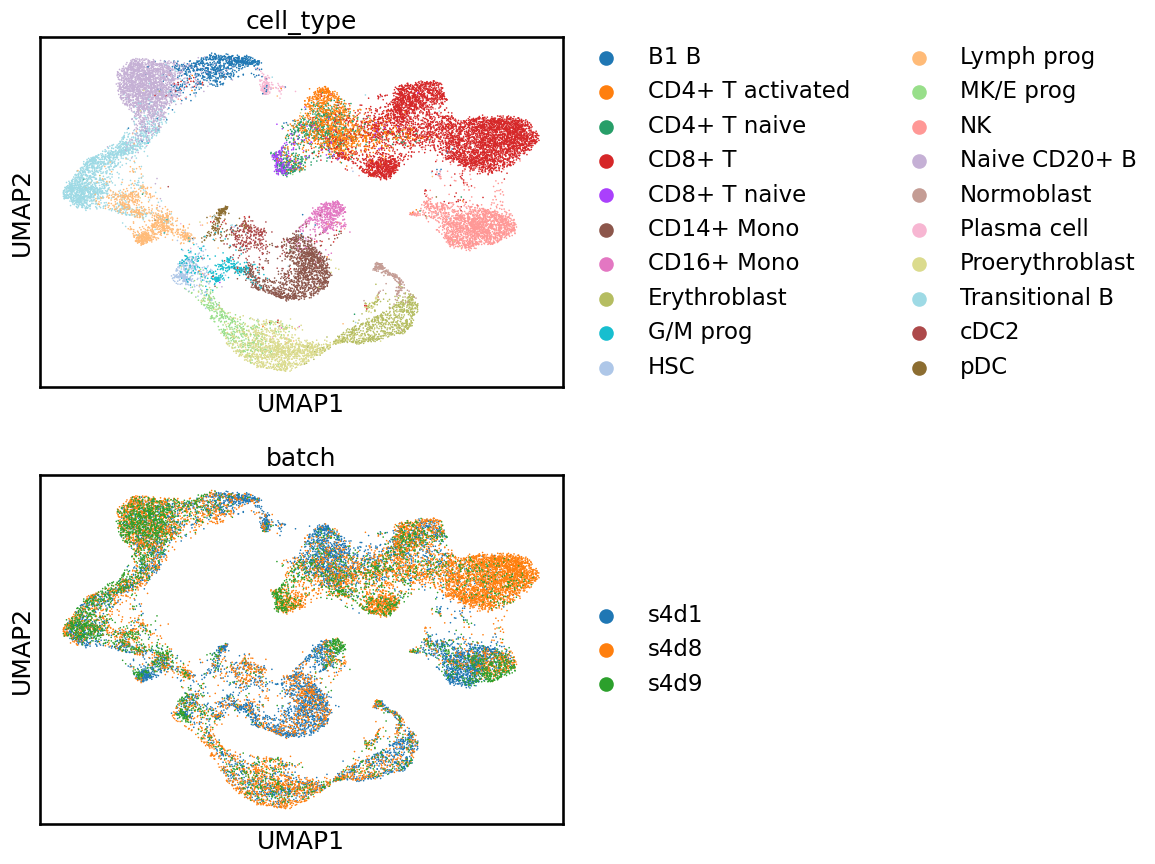

In [39]:
concat = np.concatenate((rna_adata_val.obsm['mod1_features'], atac_adata_val.obsm['mod2_features']), axis=1)
rna_adata_val.obsm['concat'] = concat

sc.pp.neighbors(rna_adata_val, use_rep='concat')
sc.tl.umap(rna_adata_val)
sc.pl.umap(rna_adata_val, color=['cell_type', 'batch'], ncols=1)

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Paramet

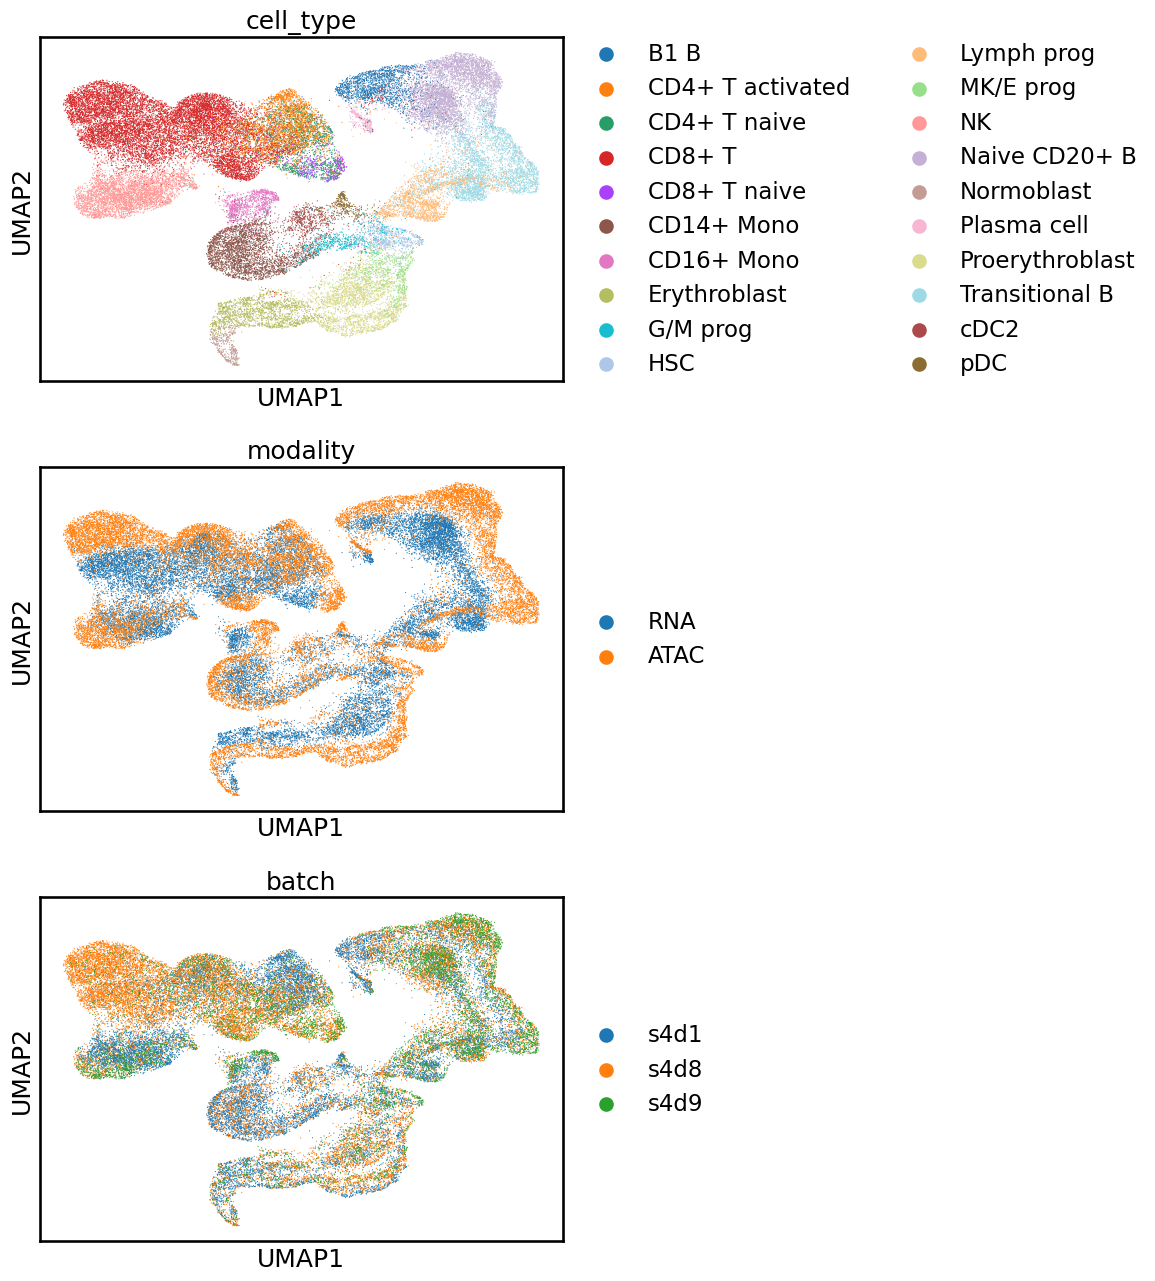

In [41]:
concat_feat = np.concatenate([rna_adata_val.obsm['mod1_features'], atac_adata_val.obsm['mod2_features']])
concat = ad.concat([rna_adata_val, rna_adata_val], label='modality', keys=['RNA', 'ATAC'])
concat.obsm['concat_feat'] = concat_feat

sc.pp.neighbors(concat, use_rep='concat_feat')
sc.tl.umap(concat)
sc.pl.umap(concat, color=['cell_type', 'modality', 'batch'], ncols=1)

In [42]:
scib.me.ilisi_graph(concat, batch_key="modality", type_="knn")

/arc/project/st-jiaruid-1/yinian/pytorch2/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


0.14900694578490925

In [43]:
scores = foscttm(rna_adata_val.obsm['mod1_features'], atac_adata_val.obsm['mod2_features'])
scores[0].mean(), scores[1].mean()

(0.029380517404180014, 0.03217372604792049)

## Re-pair the cells

To re-pair the cells, we use the embeddings on the common embedding space to perform maximum weight bipartite graph matching.

In [59]:
m1 = rna_adata_val.obsm['mod1_features']
m2 = atac_adata_val.obsm['mod2_features']
dist_matrix = sklearn.metrics.pairwise.cosine_similarity(m1, m2)

# Set a cutoff to prevent dissimilar cells from being paired together
dist_matrix[dist_matrix < 0.90] = 0

In [60]:
# row_ind contains the indices used in the RNA data, col_ind contains the indices used in the ATAC data.
row_ind, col_ind = scipy.optimize.linear_sum_assignment(dist_matrix, maximize=True)

# linear_sum_assignment will still assign pairings even if the weight is 0.
# valid_pairings captures these "false" pairings
valid_pairings = dist_matrix[row_ind, col_ind] != 0

In [61]:
# The number of successfully paired cells
valid_pairings.sum(), rna_adata_val.n_obs

(21960, 22224)

Re-arrange the RNA and ATAC data to be the re-paired data

In [62]:
rna_adata_val = rna_adata_val[row_ind[valid_pairings]]
atac_adata_val = atac_adata_val[col_ind[valid_pairings]]

rna_adata_val, atac_adata_val

(View of AnnData object with n_obs × n_vars = 21960 × 13431
     obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
     var: 'feature_types', 'gene_id'
     uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors'
     obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_scVI', 'X_umap', 'mod1_features', 'mod2_features', 'concat'
     layers: 'counts'
     obsp: 'distances', 'connectivities'

How many RNA profiles were paired to an ATAC profile of the same type.

In [70]:
sum([rna_adata_val.obs.cell_type[i] == atac_adata_val.obs.cell_type[i] for i in range(rna_adata_val.n_obs)]), rna_adata_val.n_obs

(17816, 21960)